In [10]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.optimize import minimize

I'll perform my analysis on a portfolio consisting of `Apple`, `Microsoft`, `NVIDIA`, `Netflix`. I'll create two portfolios where
the target of the high risk protfolio would be to beat the return of `Google` stocks whereas with the low risk portfolio my only taget would be to keep the volatility at minimum. I'll design my portfolio based on data gathered from the year 2019 through the end of 2022.

In [11]:
tickers = ['AAPL', 'MSFT', 'NVDA', 'NFLX', 'GOOGL']
end_date = dt.datetime(2023, 1, 1); start_date = end_date - dt.timedelta(days=4*365)
stock = yf.download(tickers, start=start_date, end=end_date)
stock.head()

C:\Users\sayak\AppData\Local\Temp\ipykernel_23848\2959137352.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  5 of 5 completed


Price           Close                                                   High  \
Ticker           AAPL      GOOGL       MSFT        NFLX      NVDA       AAPL   
Date                                                                           
2019-01-02  37.617851  52.419621  94.945534  267.660004  3.377545  37.839387   
2019-01-03  33.870838  50.967823  91.452660  271.200012  3.173483  34.711713   
2019-01-04  35.316753  53.582150  95.706055  297.570007  3.376801  35.385836   
2019-01-07  35.238152  53.475288  95.828133  315.339996  3.555571  35.452541   
2019-01-08  35.909904  53.944977  96.522934  320.269989  3.467054  36.164789   

Price                                                   ...       Open  \
Ticker          GOOGL       MSFT        NFLX      NVDA  ...       AAPL   
Date                                                    ...              
2019-01-02  52.723299  95.537063  269.750000  3.433581  ...  36.896080   
2019-01-03  52.995165  94.072300  275.790009  3.351262  ...  34.297229   
2019-01-04  53.678075  96.250641  297.799988  3.414985  ...  34.428238   
2019-01-07  53.812264  96.964248  316.799988  3.592516  ...  35.421573   
2019-01-08  54.341596  97.621491  320.589996  3.639378  ...  35.626436   

Price                                                      Volume            \
Ticker          GOOGL       MSFT        NFLX      NVDA       AAPL     GOOGL   
Date                                                                          
2019-01-02  51.053811  93.471400  259.279999  3.239190  148158800  31868000   
2019-01-03  52.220313  93.987792  270.200012  3.317293  365248800  41960000   
2019-01-04  51.817233  93.631000  281.880005  3.246628  234428400  46022000   
2019-01-07  53.726282  95.433780  302.100006  3.434077  219111200  47446000   
2019-01-08  53.976287  96.748277  319.980011  3.637146  164101200  35414000   

Price                                      
Ticker          MSFT      NFLX       NVDA  
Date                                       
2019-01-02  35329300  11679500  508752000  
2019-01-03  42579100  14969600  705552000  
2019-01-04  44060600  19330100  585620000  
2019-01-07  35656100  18620100  709160000  
2019-01-08  31514400  15359200  786016000  

[5 rows x 25 columns]

The plot below shows the relative returns of the stocks under consideration over 4 years. We see the highest volatility in `NVIDIA`

Text(0.5, 1.0, 'Normalized Returns of Selected Stocks')

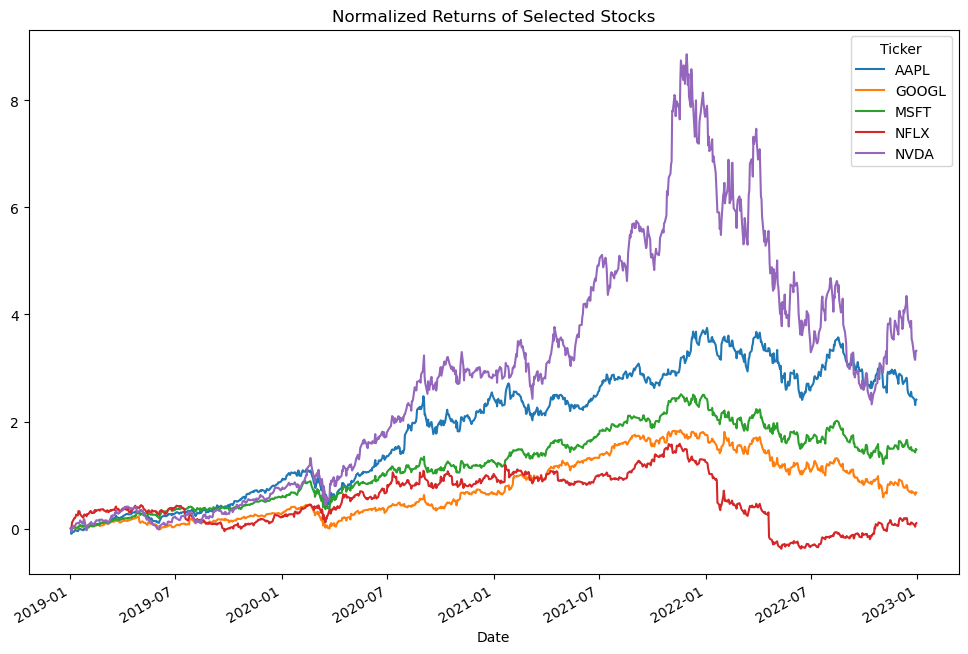

In [12]:
close_prices = stock['Close']
close_prices.head()
normalized_returns = close_prices/close_prices.iloc[0] - 1

normalized_returns.plot(figsize=(12, 8))
plt.title('Normalized Returns of Selected Stocks')

We store the log returns and of all the companies

In [13]:
log_returns = np.log(close_prices/close_prices.shift(1))
log_returns.dropna(inplace=True)
log_returns.head()

Ticker,AAPL,GOOGL,MSFT,NFLX,NVDA
Date,,,,,
2019-01-03,-0.104924,-0.028086,-0.037482,0.013139,-0.062319
2019-01-04,0.041803,0.050021,0.045460,0.092793,0.062099
2019-01-07,-0.002228,-0.001996,0.001275,0.058002,0.051587
2019-01-08,0.018884,0.008745,0.007224,0.015513,-0.025210
2019-01-09,0.016839,-0.003433,0.014198,-0.000968,0.019476


We can look at the covariances of the lg returns in the following heat maps

Text(0.5, 1.0, 'Estimated Covariance Matrix of Yearly Returns')

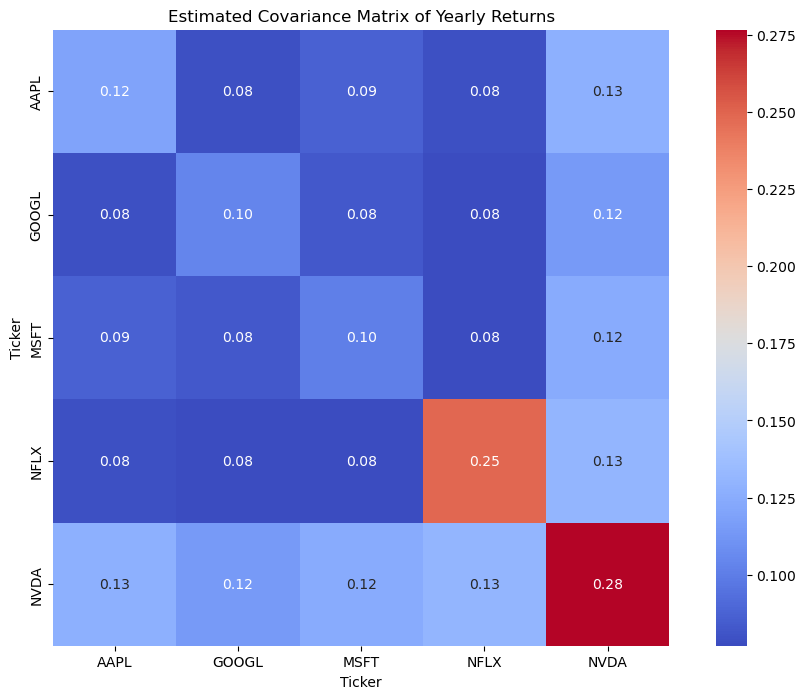

In [14]:
# estimated covariance amtrix of yearly returns
cov_all = log_returns.cov() * 252
log_returns_invest = log_returns.iloc[:,[0,2,3,4]]
cov_invest = log_returns_invest.cov() * 252
plt.figure(figsize=(12, 8))
sns.heatmap(cov_all, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Estimated Covariance Matrix of Yearly Returns')

First we store the Google log returns for the individual years

In [15]:
google_return_1 = log_returns.iloc[:251]['GOOGL'].sum()
google_return_2 = log_returns.iloc[251:503]['GOOGL'].sum()
google_return_3 = log_returns.iloc[503:756]['GOOGL'].sum()
google_return_4 = log_returns.iloc[756:]['GOOGL'].sum()

print(f"Google's return in year 1: {google_return_1:.4f}")
print(f"Google's return in year 2: {google_return_2:.4f}")
print(f"Google's return in year 3: {google_return_3:.4f}")
print(f"Google's return in year 4: {google_return_4:.4f}")

Google's return in year 1: 0.2390
Google's return in year 2: 0.2595
Google's return in year 3: 0.5120
Google's return in year 4: -0.4958


Here we optimize the weights corresponding to the stocks where the objective is to still minimize the volatility of the portfolio but with the constraint that the log-return of our protfolio beats the Google return on each year, and each company is allocated atleast 5% of the portfolio

In [16]:
# optimized portfolio with high risk

# number of assets:
n_assets = len(tickers)-1

# initial guess for weights (equal distribution)
initial_weights = np.array([1/n_assets]*n_assets)

bounds = [(0, 1) for _ in range(n_assets)]

constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
    {'type': 'ineq', 'fun': lambda weights: np.min(weights) - 5/100},
    {'type': 'ineq', 'fun': lambda weights: np.dot(log_returns_invest.iloc[:251,:].sum(axis = 0), weights) - google_return_1},
    {'type': 'ineq', 'fun': lambda weights: np.dot(log_returns_invest.iloc[251:503,:].sum(axis = 0), weights) - google_return_2},
    {'type': 'ineq', 'fun': lambda weights: np.dot(log_returns_invest.iloc[503:756,:].sum(axis = 0), weights) - google_return_3},
    {'type': 'ineq', 'fun': lambda weights: np.dot(log_returns_invest.iloc[756:,:].sum(axis = 0), weights) - google_return_4}
)


def portfolio_volatility(weights):
    portfolio_var = np.dot(weights.T, np.dot(cov_invest, weights))
    return portfolio_var

high_risk_result = minimize(portfolio_volatility,
                             initial_weights, 
                             constraints=constraints,
                             bounds=bounds)

high_risk_wt = high_risk_result.x
tickers_invested = ['AAPL', 'MSFT', 'NFLX', 'NVDA']

print('Optimal weights reached: \n')
for ticker, wt in zip(tickers_invested, high_risk_wt):
    print(f'{ticker} : {wt:.4f}')
print('\n------------------------------------------\n')
print(f'Optimal volatility reached: {np.sqrt(high_risk_result.fun):.4f}')

Optimal weights reached: 

AAPL : 0.0500
MSFT : 0.6168
NFLX : 0.0500
NVDA : 0.2832

------------------------------------------

Optimal volatility reached: 0.3501


On the other hand for the low risk portfolio, we do not impose any constraints like earlier and the sole objective is to minimize the volatility of the portfolio. It is an unconstrained optimization

In [ ]:
# optimized portfolio with low risk

# number of assets:
n_assets = len(tickers)-1

# initial guess for weights (equal distribution)
initial_weights = np.array([1/n_assets]*n_assets)
bounds = [(0, 1) for _ in range(n_assets)]
constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
)


def portfolio_volatility(weights):
    portfolio_var = np.dot(weights.T, np.dot(cov_invest, weights))
    return portfolio_var

low_risk_result = minimize(portfolio_volatility,
                             initial_weights, 
                             constraints=constraints,
                             bounds=bounds)

low_risk_wt = low_risk_result.x

tickers_invested = ['AAPL', 'MSFT', 'NFLX', 'NVDA']

print('Optimal weights reached: \n')
for ticker, wt in zip(tickers_invested, low_risk_wt):
    print(f'{ticker} : {wt:.4f}')
print('\n------------------------------------------\n')
print(f'Optimal volatility reached: {np.sqrt(low_risk_result.fun):.4f}')

Optimal weights reached: 

AAPL : 0.2655
MSFT : 0.6377
NFLX : 0.0968
NVDA : 0.0000

------------------------------------------

Optimal volatility reached: 0.3078


In the above outputs, we can see that for the high risk portfolio, the weights for `Netflix` and `Apple` are kept at the minimum of 5%. However, for the low risk portfolio we see that the weight for `NVIDIA` is 0, which makes sense since, from the plots of the relative returns we already saw that it is the most volatile. 

It makes sense that we reach a lower volatility ($\approx 31 \% $) with the low risk protfolio as compared to that of the high risk portfolio ($\approx 35\%$). In the following output we can comapre the outcome (across the 4 years 2019 through 2022) of both the portfolios with the individual returns and individual volatilities. Clearly, the high risk protfolio yields a much larger return at the cost of a higher volatility than the low risk portfolio

In [26]:
individual_volatilites = np.std(log_returns, axis = 0)*np.sqrt(252)
individual_log_returns = np.sum(log_returns, axis = 0)
# print(individual_log_returns[[0,2,3,4]])
hish_risk_return = np.dot(individual_log_returns[[0,2,3,4]], high_risk_wt)
low_risk_return = np.dot(individual_log_returns[[0,2,3,4]], low_risk_wt)
print(f'Annualized log returns from individual stocks: \n{individual_log_returns}')
print('-----'*17)
print(f'Annualized volatilities from individual stocks: \n{individual_volatilites}')
print('-----'*17)
print(f'High risk portfolio: \n log return: {hish_risk_return:.4f} and volatility: {np.sqrt(high_risk_result.fun):.4f}')
print('-----'*17)
print(f'Low risk portfolio: \n log return: {low_risk_return:.4f} and volatility: {np.sqrt(low_risk_result.fun):.4f}')

Annualized log returns from individual stocks: 
Ticker
AAPL     1.226647
GOOGL    0.514687
MSFT     0.906470
NFLX     0.096851
NVDA     1.463942
dtype: float64
-------------------------------------------------------------------------------------
Annualized volatilities from individual stocks: 
Ticker
AAPL     0.345749
GOOGL    0.321708
MSFT     0.317193
NFLX     0.498424
NVDA     0.525617
dtype: float64
-------------------------------------------------------------------------------------
High risk portfolio: 
 log return: 1.0399 and volatility: 0.3501
-------------------------------------------------------------------------------------
Low risk portfolio: 
 log return: 0.9131 and volatility: 0.3078


To test the performance of these portfolios on a test data, we shall look at their performance on the data for the years 2023 and 2024. Here also, we cna see the low risk portfolio has a lower return but with significantly lower voalatility than the high risk portfolio but the high risk portfolio manages to beat Google's return

In [25]:
end_date = dt.datetime(2024, 12, 31); start_date = dt.datetime(2023, 1, 2)
stock_2024 = yf.download(tickers, start=start_date, end=end_date)
log_returns_2024 = np.log(stock_2024['Close']/stock_2024['Close'].shift(1))
log_returns_2024.dropna(inplace = True)
log_returns_2024.head()
individual_log_returns_2024 = log_returns_2024.sum(axis = 0)
individual_volatilites_2024 = np.std(log_returns_2024, axis = 0)*np.sqrt(252)
cov_mat_2024 = 252 * log_returns_2024.iloc[:,[0,2,3,4]].cov()

high_return_2024 = np.dot(high_risk_wt, individual_log_returns_2024[[0,2,3,4]])
high_volatility_2024 = np.dot(high_risk_wt.T, np.dot(cov_mat_2024, high_risk_wt))

low_return_2024 = np.dot(low_risk_wt, individual_log_returns_2024[[0,2,3,4]])
low_volatility_2024 = np.dot(low_risk_wt.T, np.dot(cov_mat_2024, low_risk_wt))

print('2024 Individual Returns: \n----------------------------------------------')
print(f'log returns from individual stocks: \n{individual_log_returns_2024}')
print(f'Volatilities from individual stocks: \n{individual_volatilites_2024}')
print('2024 Portfolio Returns: \n----------------------------------------------')
print(f'High risk portfolio: \n log return: {high_return_2024:.4f} and volatility: {np.sqrt(high_volatility_2024):.4f}')
print(f'Low risk portfolio: \n log return: {low_return_2024:.4f} and volatility: {np.sqrt(low_volatility_2024):.4f}')


C:\Users\sayak\AppData\Local\Temp\ipykernel_23848\251621891.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_2024 = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  5 of 5 completed

2024 Individual Returns: 
----------------------------------------------
log returns from individual stocks: 
Ticker
AAPL     0.711810
GOOGL    0.767164
MSFT     0.589080
NFLX     1.116067
NVDA     2.262970
dtype: float64
Volatilities from individual stocks: 
Ticker
AAPL     0.212860
GOOGL    0.291984
MSFT     0.226526
NFLX     0.333314
NVDA     0.494322
dtype: float64
2024 Portfolio Returns: 
----------------------------------------------
High risk portfolio: 
 log return: 1.0956 and volatility: 0.2559
Low risk portfolio: 
 log return: 0.6727 and volatility: 0.1963
